In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import random
import shutil
from shutil import copyfile
from PIL import ImageOps
from sklearn.metrics import confusion_matrix
from scipy.spatial.distance import euclidean
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.applications import VGG16
from keras.layers import Dense, Input, Dropout, Flatten, Conv2D, BatchNormalization, Activation
from keras.layers import GlobalAveragePooling2D, MaxPooling2D 
from keras.models import Model, Sequential
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard

In [15]:
# Creating mixed emotion folders
base_path = r"C:\Users\LENOVO\Documents\DL_emotions"
train_path = os.path.join(base_path, "train")
validation_path = os.path.join(base_path, "validation")
train_combo_path = os.path.join(base_path, "train_combo")
validation_combo_path = os.path.join(base_path, "validation_combo")

# Creating destination folders
os.makedirs(train_combo_path, exist_ok=True)
os.makedirs(validation_combo_path, exist_ok=True)

In [19]:
emotions = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

for emotion in emotions:
  source_path = os.path.join(train_path, emotion)
  destination_path = os.path.join(train_combo_path, emotion)
  os.makedirs(destination_path, exist_ok=True)  # Create destination folder 

  # Copy all files from source to destination
  for filename in os.listdir(source_path):
    source = os.path.join(source_path, filename)
    destination = os.path.join(destination_path, filename)
    os.replace(source, destination)  

for emotion in emotions:
  source_path = os.path.join(validation_path, emotion)
  destination_path = os.path.join(validation_combo_path, emotion)
  os.makedirs(destination_path, exist_ok=True)

  # Copy all files from source to destination
  for filename in os.listdir(source_path):
    source = os.path.join(source_path, filename)
    destination = os.path.join(destination_path, filename)
    os.replace(source, destination)  

In [21]:
# Data preparation and Model training
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
validation_datagen = ImageDataGenerator(rescale=1./255)

# Defining training and validation generators
train_generator = train_datagen.flow_from_directory(
    train_combo_path,
    target_size=(48, 48),  
    batch_size=32,
    class_mode='categorical'  
)

validation_generator = validation_datagen.flow_from_directory(
    validation_combo_path,
    target_size=(48, 48),
    batch_size=32,
    class_mode='categorical'
)


Found 6 images belonging to 7 classes.
Found 7 images belonging to 7 classes.


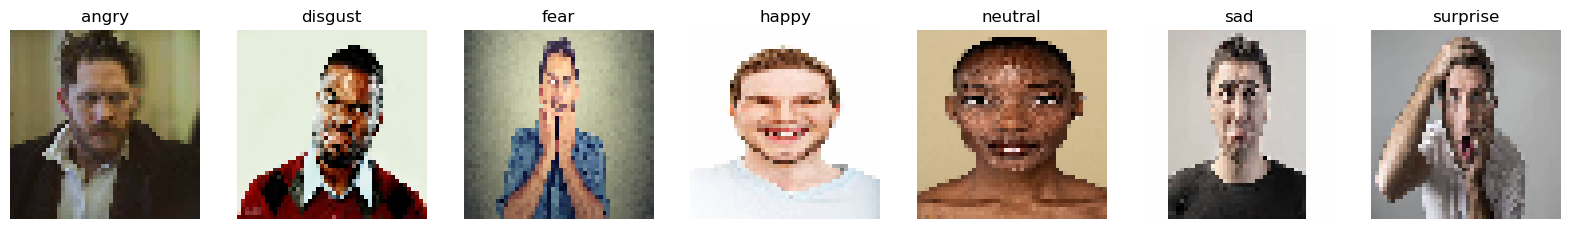

In [23]:
# Function to load and preprocess images
def load_and_preprocess_image(image_path, target_size=(48, 48)):
    image = load_img(image_path, target_size=target_size)
    image_array = img_to_array(image)
    image_array /= 255.0  # Normalize the image
    return image_array

# Plot a sample image from each category
fig, axes = plt.subplots(1, len(emotions), figsize=(20, 5))

for i, emotion in enumerate(emotions):
    # Get the path of the first image in each category
    emotion_path = os.path.join(train_combo_path, emotion)
    image_files = os.listdir(emotion_path)
    
    if not image_files:  # Skip if the category directory is empty
        print(f"No images found in category '{emotion}'")
        continue
    
    first_image_path = os.path.join(emotion_path, image_files[0])
    
    # Load and preprocess the image
    image = load_and_preprocess_image(first_image_path)
    
    # Plot the image
    axes[i].imshow(image)
    axes[i].set_title(emotion)
    axes[i].axis('off')

plt.show()


In [24]:
# Defining the model architecture
model = Sequential([
  Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 3)),
  MaxPooling2D((2, 2)),
  Conv2D(64, (3, 3), activation='relu'),
  MaxPooling2D((2, 2)),
  Flatten(),
  Dense(64, activation='relu'),  
  Dense(7, activation='softmax') 
])

# Compiling the model (specifying optimizer and loss function)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

C:\Users\LENOVO\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
# Training the model with Early Stopping

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)  
 
model.fit(
  train_generator,
  epochs=30, 
  validation_data=validation_generator,
  callbacks=[early_stopping]
)

Epoch 1/30


C:\Users\LENOVO\AppData\Local\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1667 - loss: 2.0025 - val_accuracy: 0.1429 - val_loss: 1.9143
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.1667 - loss: 1.8827 - val_accuracy: 0.1429 - val_loss: 1.8897
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.1667 - loss: 1.8236 - val_accuracy: 0.1429 - val_loss: 1.8699
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.1667 - loss: 1.7703 - val_accuracy: 0.1429 - val_loss: 1.8392
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.1667 - loss: 1.7406 - val_accuracy: 0.4286 - val_loss: 1.8015
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.5000 - loss: 1.6681 - val_accuracy: 0.4286 - val_loss: 1.7352
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.3333 - loss: 1.6156 - val_accuracy: 0.4286 - val_loss: 1.6832
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.3333 - loss: 1.5731 - val_accuracy: 0.5714 - val_loss: 1.6146
Epoch 

In [26]:
model = Sequential([
  Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 3)),
  MaxPooling2D((2, 2)),
  Conv2D(64, (3, 3), activation='relu'),
  MaxPooling2D((2, 2)),
  Flatten(),
  Dense(64, activation='relu'),  
  Dense(7, activation='softmax')  
])

In [27]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(
  train_generator,
  epochs=30,  
  validation_data=validation_generator
)

history = model.history
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.0000e+00 - loss: 1.9808 - val_accuracy: 0.1429 - val_loss: 1.9473
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.1667 - loss: 1.9144 - val_accuracy: 0.2857 - val_loss: 1.9077
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.3333 - loss: 1.8322 - val_accuracy: 0.1429 - val_loss: 1.8551
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.1667 - loss: 1.7969 - val_accuracy: 0.1429 - val_loss: 1.8099
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.3333 - loss: 1.7428 - val_accuracy: 0.4286 - val_loss: 1.7391
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.5000 - loss: 1.6585 - val_accuracy: 0.4286 - val_loss: 1.6883
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.3333 - loss: 1.6424 - val_accuracy: 0.5714 - val_loss: 1.6450
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.6667 - loss: 1.5290 - val_accuracy: 0.7143 - val_loss

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Predicted Emotion for C:\Users\LENOVO\Documents\DL_emotions\train_combo\angry\Angry-DL.jpg: fear


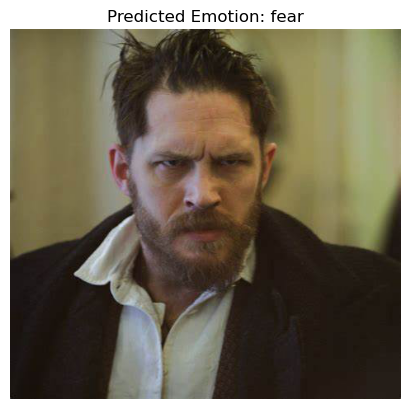

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Predicted Emotion for C:\Users\LENOVO\Documents\DL_emotions\train_combo\disgust\Disgusted-DL.jpg: disgust


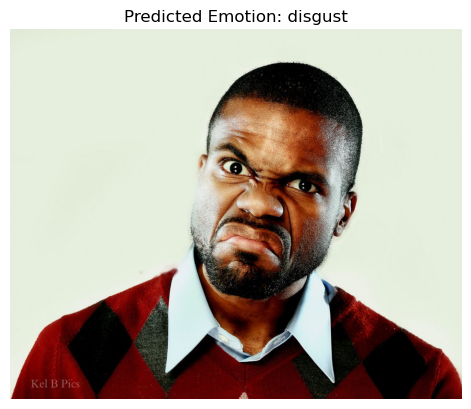

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted Emotion for C:\Users\LENOVO\Documents\DL_emotions\train_combo\fear\Fear-DL.jpg: fear


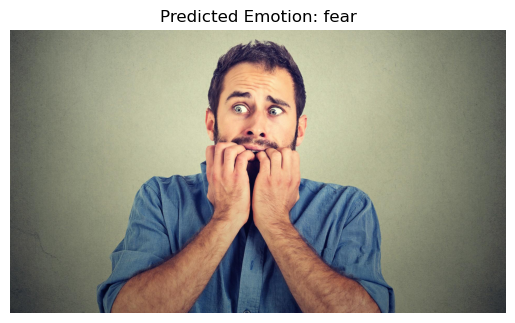

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted Emotion for C:\Users\LENOVO\Documents\DL_emotions\train_combo\happy\happy-DL.jpg: happy


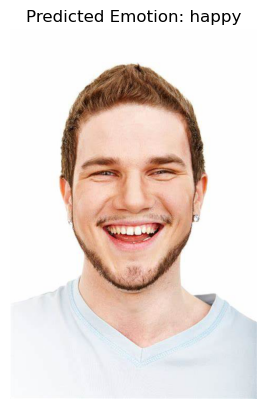

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted Emotion for C:\Users\LENOVO\Documents\DL_emotions\train_combo\neutral\neutral-DL.jpg: neutral


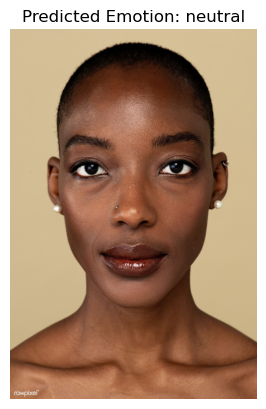

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted Emotion for C:\Users\LENOVO\Documents\DL_emotions\train_combo\sad\sad- DL.jpg: sad


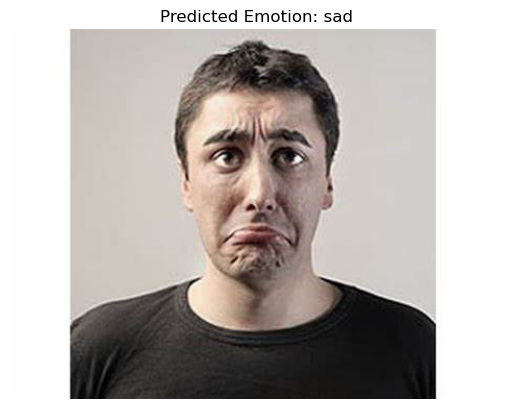

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted Emotion for C:\Users\LENOVO\Documents\DL_emotions\train_combo\surprise\suprise.jpg: surprise


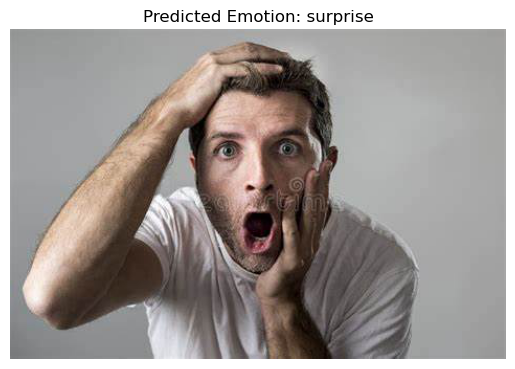

In [29]:
def predict_emotion(preprocessed_image):
    # Use the trained model to predict
    predictions = model.predict(preprocessed_image)
    return predictions

def load_and_preprocess_image(image_path, target_size=(48, 48)):
    # Load the image
    image = load_img(image_path, target_size=target_size)
    # Convert the image to an array
    image_array = img_to_array(image)
    # Scale the pixel values to [0, 1]
    image_array = image_array / 255.0
    # Add batch dimension
    image_array = np.expand_dims(image_array, axis=0)
    return image_array

image_paths = [
    r"C:\Users\LENOVO\Documents\DL_emotions\train_combo\angry\Angry-DL.jpg",
    r"C:\Users\LENOVO\Documents\DL_emotions\train_combo\disgust\Disgusted-DL.jpg",
    r"C:\Users\LENOVO\Documents\DL_emotions\train_combo\fear\Fear-DL.jpg",
    r"C:\Users\LENOVO\Documents\DL_emotions\train_combo\happy\happy-DL.jpg",
    r"C:\Users\LENOVO\Documents\DL_emotions\train_combo\neutral\neutral-DL.jpg",
    r"C:\Users\LENOVO\Documents\DL_emotions\train_combo\sad\sad- DL.jpg",
    r"C:\Users\LENOVO\Documents\DL_emotions\train_combo\surprise\suprise.jpg",
]

categories = ["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]

for image_path in image_paths:
    # Load and preprocess the image
    preprocessed_image = load_and_preprocess_image(image_path)

    # Get model predictions
    predictions = predict_emotion(preprocessed_image)

    # Get the index of the class with the highest probability
    predicted_class_index = np.argmax(predictions[0])

    # Get the predicted emotion
    predicted_emotion = categories[predicted_class_index]

    # Print the prediction
    print(f"Predicted Emotion for {image_path}: {predicted_emotion}")

    # Display the image and prediction
    plt.figure()
    plt.imshow(load_img(image_path))
    plt.title(f"Predicted Emotion: {predicted_emotion}")
    plt.axis('off')  # Hide the axes
    plt.show()